# Import libraries

In [192]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import collections
import re
import string
import matplotlib.pyplot as plt
from collections import defaultdict
from bs4 import BeautifulSoup

from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import initializers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Layer, InputSpec, TextVectorization
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, MaxPooling1D,GRU, Bidirectional
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from __future__ import division, print_function

os.environ['KERAS_BACKEND']='theano'
plt.switch_backend('agg')
%matplotlib inline

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

nltk and gensim are two famous libraries that are used in Natural Language Processing (NLP). nltk library has been used to get the stop words of English language and to lemmatize words. Also gensim library has been used to load the Doc2vec model

In [193]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [194]:
proj_dir='/content/drive/MyDrive/Colab Notebooks/' #give your project directory here. data sets should be in this location

# Load and clean the data

before converting into vectors text should be cleaned.

* Lower the english latters
* Remove headers
* Drop all digits
* Remove URLs and Emails
* Drop all punctuation from our text
* Drop stop words
* Lemmatize words


first, we convert all the letters into lowercase letters in order to avoid duplicating the same word ('Dog' and 'dog' are the same words. but the program will take these as two words. Hence we convert 'Dog' as 'dog' by doing letters lowercase)

After that we drop all the headers and numbers.Because headers are unwanted data and numbers don't have any meaning when we take them as a single word.

if any word contains '@','.com' or 'http' we drop those words. also we remove all punctuations and stop words. The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words such as “the”, “a”, “an”, “so”, “what” in English language. By removing these words, we remove the low-level information from our text in order to give more focus to the important information.

finally we lemmatize words. Lemmatization is the process wherein the context is used to convert a word to its meaningful base or root form. ex:- driving--> drive , dogs-->dog. To perform Lemmatization with Natural Language Tool Kit (NLTK), “WordNetLemmatizer()” method has been used

In [ ]:
'''this function is used to read text files.'''
def read_txt_file(file_name):
    with open(file_name,encoding="utf8", errors='ignore') as f:
        ###extract the boady of the text###
        line = f.readline()
        txt=''
        txt=txt+' '+line
        while line:
            line = f.readline()
            txt=txt+' '+line
        ###################################
    f.close()
    return(txt)

In [ ]:
stop_words=set(stopwords.words('english'))#load stop words
punctuations=string.punctuation #get punctuations
lemmatizer = WordNetLemmatizer()
'''this function is used to clean text'''
def clean_txt(txt):
    txt=txt.lower() #set all characters to lowercase
    sentences=txt.split('\n')
    txt = ' '.join([i for i in sentences if not ':' in i])#remove headers
    txt = ''.join([i for i in txt if not i.isdigit()])#remove numbers

    ###remove urls and emails###
    words=txt.split()
    txt = ' '.join([i for i in words if not '@' in i and not '.com' in i and not  'http:' in i])
    #######################################

    ###remove punctuations###
    for character in punctuations:
        txt = txt.replace(character, '')
    #########################################
    
    ###remove stop words and lemmatize###
    words=txt.split()
    filtered_txt = ' '.join([lemmatizer.lemmatize(i) for i in words if not i in stop_words])
    #####################################
    
    return(filtered_txt)

In [ ]:
def load_and_clean_data(location):    
    y=os.listdir(location)#get the list of folder
    txts=[]
    txts_cleaned=[]
    folder_array=[]
    file_array=[]
    for i in range(len(y)):
        text_file_names=os.listdir(location+'/'+y[i]) #get the list of files
        for text_file_name in text_file_names:
                file_array.append(text_file_name)
                txt=read_txt_file(location+'/'+y[i]+'/'+text_file_name) #read the text file
                txts.append(txt)
                txts_cleaned.append(clean_txt(txt)) #clean the text
                folder_array.append(y[i])

    ###create a data frame###
    df=pd.DataFrame()
    df['texts']=txts
    df['text cleaned']=txts_cleaned
    df['folder name']=folder_array
    df['file name']=file_array
    ########################
    return (df)



In [ ]:
df_train=load_and_clean_data(proj_dir+'20news-bydate-train')
df_test=load_and_clean_data(proj_dir+'20news-bydate-test')

In [ ]:
df_train.head()

In [ ]:
df_test.head()

# Convert to vectors

document is tokenized into words and applied doc2vec model. doc2vec is a method to represent list of words using a vector. it is used to create a vectorised representation of a group of words taken collectively as a single unit.In gensim the model will always be trained on a word per word basis. Therefore  we split the document into an array of words using split(). In order to train the model, tagged documents are needed. it can be created by using models.doc2vec.TaggedDcument(). then finally we train the doc2vec model

In [ ]:
'''this function is used to do tokenization'''
def tokenizer(txt):  
    tokens=txt.split(' ')
    unique_tokens=np.unique(np.array(tokens)) #get unique tokens
    ###create a dictonary of tokens###
    tokens_dict={}
    for indx in range(len(unique_tokens)):
        tokens_dict[unique_tokens[indx]]=indx
    return(tokens_dict,tokens)

In [ ]:
#tokanize train and test data
words_list=[]
for i in range(len(df_train)):
    _,words=tokenizer(df_train['text cleaned'][i]) 
    words_list.append(words)
for i in range(len(df_test)):
    _,words=tokenizer(df_test['text cleaned'][i])
    words_list.append(words)
####################################

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(words_list)]
model = Doc2Vec(vector_size=40, min_count=2, epochs=30) #fit the Doc2Vec model
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
###get train vectors##
train_vectors=[]
for i in range(len(df_train)):
    train_vectors.append(model.infer_vector(list(df_train['text cleaned'][i].split(' '))))
##########################

In [ ]:
##get test vectors##
test_vectors=[]
for i in range(len(df_test)):
    test_vectors.append(model.infer_vector(list(df_test['text cleaned'][i].split(' '))))
############################

In [ ]:
train=pd.DataFrame(train_vectors)
train['folder name']=df_train['folder name']
train['file name']=df_train['file name']
test=pd.DataFrame(test_vectors)
test['folder name']=df_test['folder name']
test['file name']=df_test['file name']

In [ ]:
train.head()

In [ ]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,folder name,file name
0,-0.829039,0.595767,0.272339,-0.777664,-0.302763,0.004177,0.268033,-0.485166,-0.843002,0.257571,...,-0.238120,-0.127876,0.146366,-0.114035,-0.309343,0.049507,-0.628957,-0.295396,comp.windows.x,67551
1,-0.007977,0.157579,-0.441581,-0.248513,-0.173512,0.375976,-0.167974,-0.184429,-0.935126,-0.240099,...,-0.044515,0.069662,0.189067,-0.123367,0.005701,-0.110369,-0.089204,-0.165628,comp.windows.x,67566
2,-0.308539,-0.235057,-0.031315,-1.145314,-0.644860,-0.157424,0.514816,-0.619588,-0.808261,0.625899,...,0.635271,0.688951,0.615576,-0.537781,-0.447920,0.390655,-0.642817,-1.313284,comp.windows.x,68196
3,-2.770799,3.227902,7.109700,0.274504,-0.745340,-0.626961,3.768921,-6.024498,-2.039409,2.525901,...,3.065503,-2.838213,-3.259711,-2.036948,-1.627054,-6.080042,-2.169715,0.587561,comp.windows.x,68332.eml
4,0.802032,-0.426742,0.006351,0.164876,-0.639802,0.363767,0.932702,-0.697396,-2.557853,-0.520898,...,0.344609,0.934438,0.046972,-0.175961,-1.186803,0.030826,-0.889382,-0.739124,comp.windows.x,67972


In [ ]:
train_,validation=train_test_split( train, test_size=0.33, random_state=42) #split data into train and validation sets

In [ ]:
len(train_),len(test),len(validation)

(7580, 7537, 3734)

In [ ]:
#save data sets
train_.to_csv(proj_dir+'train_data.csv')
test.to_csv(proj_dir+'test_data.csv')
validation.to_csv(proj_dir+'validation_data.csv')

# Modeling

## Load data

In [205]:
#read data which was saved in the feature generation part
train=pd.read_csv(proj_dir+'train_data.csv')
test=pd.read_csv(proj_dir+'test_data.csv')
validation=pd.read_csv(proj_dir+'validation_data.csv')

## Data rearrange for modeling

In [206]:
#extract X and y data from data frames
X_train=train[[str(i) for i in range(40)]]
y_train=train['folder name']

X_test=test[[str(i) for i in range(40)]]
y_test=test['folder name']

X_validation=validation[[str(i) for i in range(40)]]
y_validation=validation['folder name']

In [207]:
names=np.unique(np.array(y_train)) #getting unique categories
print(names)

['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


In [208]:
# Category mapping
y_train_en=[np.where(names==name)[0] for name in y_train ]
y_test_en=[np.where(names==name)[0] for name in y_test ]
y_validation_en=[np.where(names==name)[0] for name in y_validation ]

In [209]:
# Category encoding
# keras.utils.to_categorical is a function used to Converts a class vector (integers) to binary class matrix
# so by the end of this code block we will have encoded categories so we are ready to use it in the model. 
y_train_en=keras.utils.to_categorical(y_train_en)
y_test_en=keras.utils.to_categorical(y_test_en)
y_validation_en=keras.utils.to_categorical(y_validation_en)

## Model

In [216]:
### building the model
classifier = Sequential() #The sequential API allows you to create models layer-by-layer for most problems.
classifier.add(Dense(units=100, input_dim=40, kernel_initializer='uniform', activation='relu'))# relu (Rectifier linear unit) function
classifier.add(Dense(units=80, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.2)) # dropout layer to prevent overfitting
classifier.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.2)) # dropout layer to prevent overfitting
classifier.add(Dense(units=30, kernel_initializer='uniform', activation='relu'))

####################### Output layer############################################
# sigmoid means sigmoid activation function
# for Multiclass classification the activation ='softmax'
classifier.add(Dense(units=20, kernel_initializer='uniform', activation='sigmoid'))
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 100)               4100      
                                                                 
 dense_14 (Dense)            (None, 80)                8080      
                                                                 
 dropout_10 (Dropout)        (None, 80)                0         
                                                                 
 dense_15 (Dense)            (None, 60)                4860      
                                                                 
 dropout_11 (Dropout)        (None, 60)                0         
                                                                 
 dense_16 (Dense)            (None, 30)                1830      
                                                                 
 dense_17 (Dense)            (None, 20)               

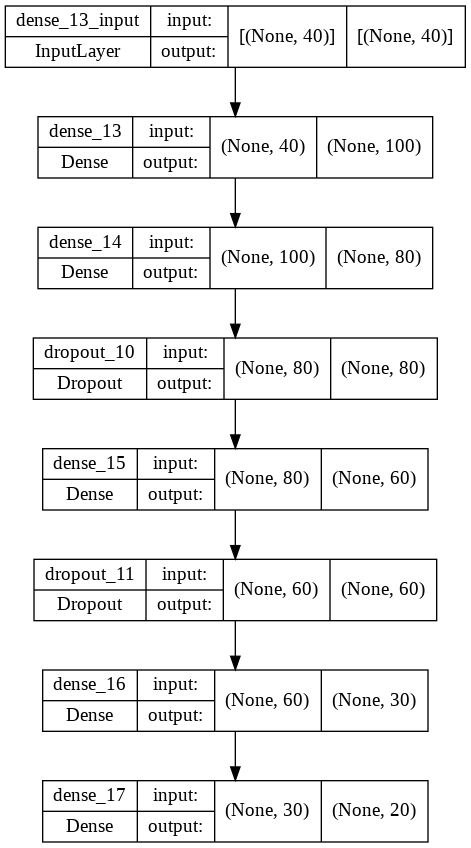

In [217]:
plot_model(classifier, to_file=proj_dir+'model_plot.png', show_shapes=True, show_layer_names=True) # plot and save the model diagramm

In [218]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #compile the model

# fitting the Neural Network on the training data
history=classifier.fit(X_train,y_train_en,validation_data=(X_validation, y_validation_en), batch_size=50 , epochs=40, verbose=1)

Epoch 1/40
152/152 [==============================] - 2s 6ms/step - loss: 0.3112 - accuracy: 0.0536 - val_loss: 0.2095 - val_accuracy: 0.0474
Epoch 2/40
152/152 [==============================] - 1s 5ms/step - loss: 0.2074 - accuracy: 0.0521 - val_loss: 0.2011 - val_accuracy: 0.0495
Epoch 3/40
152/152 [==============================] - 1s 5ms/step - loss: 0.2014 - accuracy: 0.0499 - val_loss: 0.1988 - val_accuracy: 0.0541
Epoch 4/40
152/152 [==============================] - 1s 5ms/step - loss: 0.2007 - accuracy: 0.0492 - val_loss: 0.1989 - val_accuracy: 0.0474
Epoch 5/40
152/152 [==============================] - 1s 5ms/step - loss: 0.2004 - accuracy: 0.0518 - val_loss: 0.1992 - val_accuracy: 0.0469
Epoch 6/40
152/152 [==============================] - 1s 4ms/step - loss: 0.2005 - accuracy: 0.0491 - val_loss: 0.1988 - val_accuracy: 0.0541
Epoch 7/40
152/152 [==============================] - 1s 5ms/step - loss: 0.2004 - accuracy: 0.0492 - val_loss: 0.1986 - val_accuracy: 0.0487
Epoch 

### Evaluate

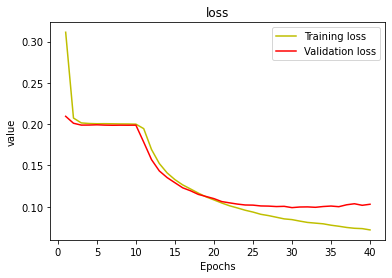

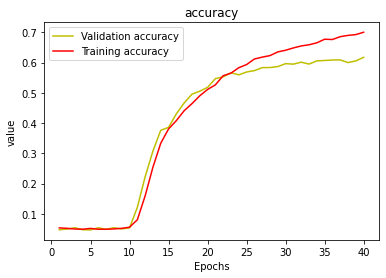

In [219]:
#plotting trainning, validation accuracies and losses
loss = history.history['loss']
loss_val = history.history['val_loss']
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='Validation loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('value')
plt.legend()
plt.show()

plt.plot(epochs, acc_val, 'y', label='Validation accuracy')
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('value')
plt.legend()
plt.show()

In [220]:
#calculate the test accuracy
y_pred=np.argmax(classifier.predict(X_test),axis=1) #predict on test data
y_true=np.argmax(y_test_en,axis=1) #true values
acc=sum(y_pred==y_true)/len(y_pred) #calculate the accuracy
print('test accuracy : ',acc)

test accuracy :  0.5596658711217184


## Naive Bayes

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [ ]:
# combine validation and training sets to do grid search
X_train_val = pd.concat([X_train, X_validation], axis = 0)
X_train_val = X_train_val.reset_index(drop = True)

# y_train_val = pd.concat([y_train, y_validation], axis = 0)
# y_train_val = y_train_val.reset_index(drop = True)

In [ ]:
y_train_val = np.concatenate((y_train_en, y_validation_en))
y_train_val  = pd.DataFrame(y_train_val).apply(lambda x: x.argmax(), axis=1).values
y_train_val

array([13, 16, 15, ...,  5,  9, 17])

In [ ]:
y_test = pd.DataFrame(y_test_en).apply(lambda x: x.argmax(), axis=1).values

#### grid search 

In [ ]:
# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1] * len(X_train) + [0] * len(X_validation)
pds = PredefinedSplit(test_fold = split_index)

gnb_clf = GaussianNB()
parameters = {
    'var_smoothing': [1e-1,1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}
clf = GridSearchCV(gnb_clf, parameters, cv=pds, verbose=1, n_jobs=1) #it is hold-out validation here
clf.fit(X_train_val, y_train_val)

print('Best parameter:',clf.best_params_) #best performance on training set and its parameter
print('Best train accuracy score:', clf.best_score_)

Fitting 1 folds for each of 15 candidates, totalling 15 fits
Best parameter: {'var_smoothing': 0.0001}
Best train accuracy score: 0.3891269416175683


In [ ]:
#grid search performance
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

,var_smoothing,Accuracy
0,1.000000e-01,0.374397
1,1.000000e-02,0.385913
2,1.000000e-03,0.388591
3,1.000000e-04,0.389127
4,1.000000e-05,0.389127
5,1.000000e-06,0.389127
6,1.000000e-07,0.389127
7,1.000000e-08,0.389127
8,1.000000e-09,0.389127
9,1.000000e-10,0.389127


In [ ]:
#performance on test set
nb_pred = clf.best_estimator_.predict(X_test)
print('Test accuracy score:', accuracy_score(y_test, nb_pred))

macro_averaged_precision = precision_score(y_test, nb_pred, average = 'macro')
print('Test macro averaged precision score:', macro_averaged_precision)

recall = recall_score(y_test, nb_pred, average = 'macro')
print('Test recall score:', recall)

macro_averaged_f1 = f1_score(y_test, nb_pred, average = 'macro')
print('Test macro averaged f1 score:', macro_averaged_f1)

Test accuracy score: 0.3843808008485813
Test macro averaged precision score: 0.47174173772239375
Test recall score: 0.3759985411740378
Test macro averaged f1 score: 0.3839293190524554


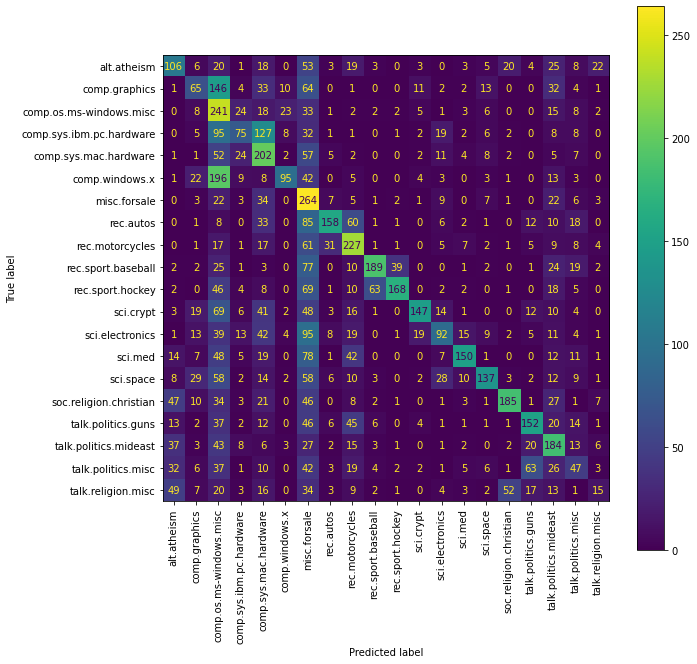

In [ ]:
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#### grid search

In [ ]:
k_range = list(range(1, 31)) # possible k

param_grid = dict(n_neighbors=k_range)

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, param_grid, cv=pds, verbose=1, n_jobs=1)
  
# fitting the model for grid search
clf =clf.fit(X_train_val, y_train_val)
print('Best parameter:',clf.best_params_) #best performance on training set and its parameter
print('Best train accuracy score:', clf.best_score_)

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Best parameter: {'n_neighbors': 1}
Best train accuracy score: 0.5551687198714516


In [ ]:
#grid search performance
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

,n_neighbors,Accuracy
0,1,0.555169
1,2,0.488752
2,3,0.509909
3,4,0.521157
4,5,0.533208
5,6,0.528656
6,7,0.533476
7,8,0.532405
8,9,0.535619
9,10,0.537225


In [ ]:
#performance on test set
knn_pred = clf.best_estimator_.predict(X_test)
print('Test accuracy score:', accuracy_score(y_test, knn_pred))

macro_averaged_precision = precision_score(y_test, knn_pred, average = 'macro')
print('Test macro averaged precision score:', macro_averaged_precision)

recall = recall_score(y_test, knn_pred, average = 'macro')
print('Test recall score:', recall)

macro_averaged_f1 = f1_score(y_test, knn_pred, average = 'macro')
print('Test macro averaged f1 score:', macro_averaged_f1)

Test accuracy score: 0.4573057544417926
Test macro averaged precision score: 0.4632599793425438
Test recall score: 0.4506451529410353
Test macro averaged f1 score: 0.4539581866931983


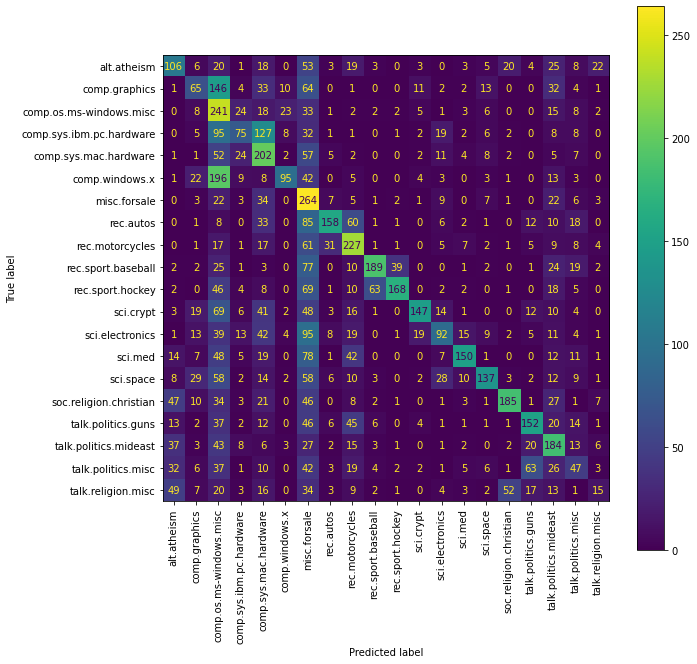

In [ ]:
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()

## 1 dimensional CNN | Conv1D-without using Pre-trained Embedding

In [ ]:
#define X and y
X = df_train['texts']
y = df_train['folder name']
X_test=df_test['texts']
y_test=df_test['folder name']

X_train, X_val = train_test_split(X, test_size=0.33, random_state=42) #use the same split seed as that used in knn and nb
y_train, y_val = train_test_split(y, test_size=0.33, random_state=42)

In [ ]:
names=np.unique(np.array(y_train)) #getting unique categories
print(names)

['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


#### Creat Text Vectorization from Training Dataset

In [ ]:
# Creating vectorizer and adapting to the training data to be use for all data,restriced to 20,000 vocabulary
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train.values.tolist())
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 200

#### Prepare Input Data for CNN Model

In [ ]:
class_names=y.unique()
label_names=list(class_names)
label_index=(np.unique(label_names, return_inverse=True)[1])
label_code=(np.unique(y, return_inverse=True)[1])

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(7580,) (3734,)
(7580,) (3734,)


In [ ]:
x_train = vectorizer(np.array([[s] for s in X_train.values.tolist()])).numpy()
x_val = vectorizer(np.array([[s] for s in X_val.values.tolist()])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test.values.tolist()])).numpy()

In [ ]:
y_train=np.array(np.unique(y_train, return_inverse=True)[1])
y_val=(np.unique(y_val, return_inverse=True)[1])
y_test=(np.unique(y_test, return_inverse=True)[1])

In [ ]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(num_tokens, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a multiclass unit output layer, and squash it with a softmax:
predictions = layers.Dense(len(label_names), activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with multiclass crossentropy loss and an rmsprop optimizer.
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
print("Simple Neural Network")
model.summary()

Simple Neural Network
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 200)         4000400   
                                                                 
 dropout_4 (Dropout)         (None, None, 200)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         179328    
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                     

#### Graphical representation of CNN Model

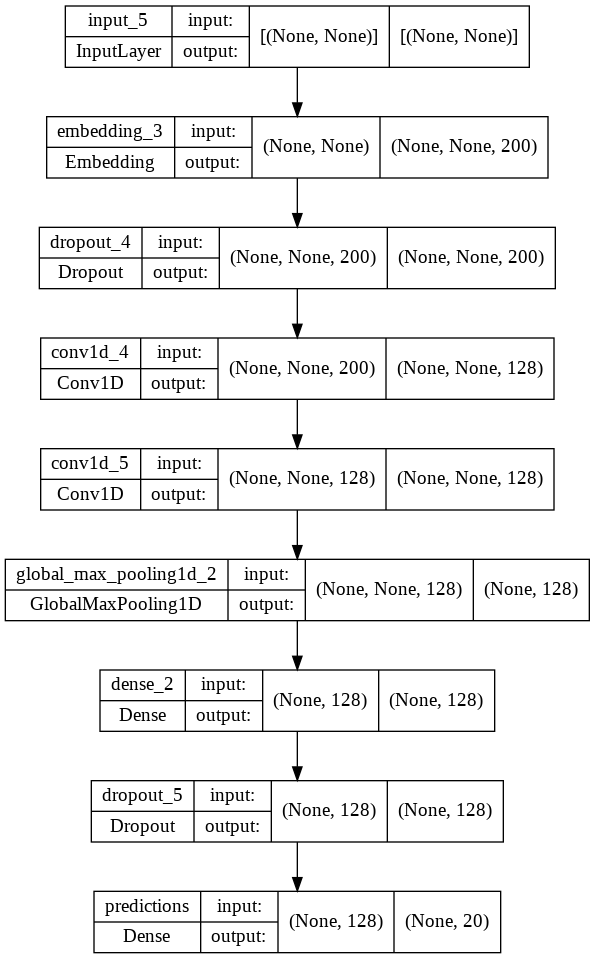

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

#### Model Training

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [ ]:
epochs = 50
batch_size=64
# Fit the model using the train and test datasets.
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=epochs,batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 39s 308ms/step - loss: 2.9850 - accuracy: 0.0621 - val_loss: 2.9484 - val_accuracy: 0.0838
Epoch 2/50
119/119 [==============================] - 37s 311ms/step - loss: 2.7323 - accuracy: 0.1074 - val_loss: 2.4362 - val_accuracy: 0.1687
Epoch 3/50
119/119 [==============================] - 36s 303ms/step - loss: 2.2635 - accuracy: 0.2162 - val_loss: 1.9558 - val_accuracy: 0.3597
Epoch 4/50
119/119 [==============================] - 37s 306ms/step - loss: 1.7197 - accuracy: 0.3892 - val_loss: 1.4319 - val_accuracy: 0.5174
Epoch 5/50
119/119 [==============================] - 37s 308ms/step - loss: 1.2515 - accuracy: 0.5478 - val_loss: 1.1705 - val_accuracy: 0.6355
Epoch 6/50
119/119 [==============================] - 36s 301ms/step - loss: 0.8971 - accuracy: 0.6951 - val_loss: 0.9568 - val_accuracy: 0.7078
Epoch 7/50
119/119 [==============================] - 36s 301ms/step - loss: 0.6090 - accuracy: 0.7927 - val_loss: 0.9349 - val_ac

#### Exhibit Accuracy and Validation Loss of CNN Model

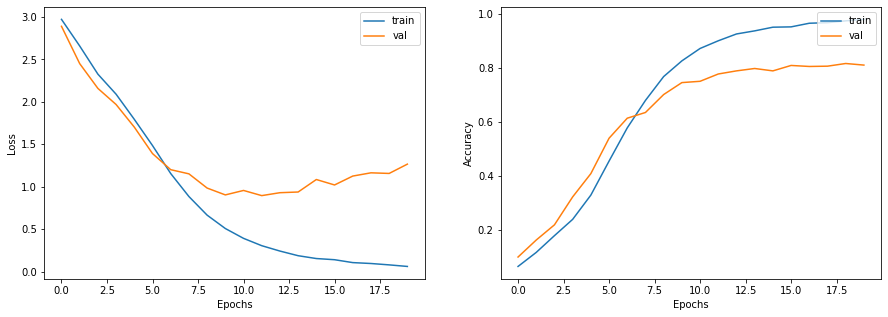

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history2.history["loss"])
ax1.plot(history2.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history2.history["accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

#### Performance of CNN Model on Test Set

In [ ]:
_, test_accuracy = model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 72.3%


In [ ]:
cnn_pred = model.predict(x_test)
cnn_pred = pd.DataFrame(cnn_pred).apply(lambda x: x.argmax(), axis=1).values

In [ ]:
macro_averaged_precision = precision_score(y_test, cnn_pred, average = 'macro')
print('Test macro averaged precision score:', macro_averaged_precision)

recall = recall_score(y_test, cnn_pred, average = 'macro')
print('Test recall score:', recall)

macro_averaged_f1 = f1_score(y_test, cnn_pred, average = 'macro')
print('Test macro averaged f1 score:', macro_averaged_f1)

Test macro averaged precision score: 0.7370217244948821
Test recall score: 0.7195147027354419
Test macro averaged f1 score: 0.7240918582668144


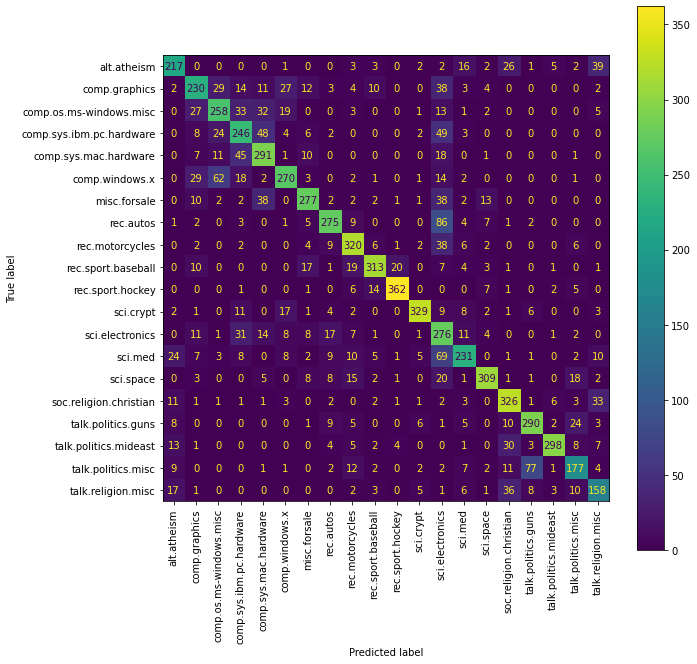

In [ ]:
cm = confusion_matrix(y_test, cnn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()